<a href="https://colab.research.google.com/github/smkirby/medal/blob/main/medal_2_bonus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Medal summer school, Lab 2 bonus, Gene-culture coevolution!


We're going to use the same code as the main lab to do something similar to [Smith & Kirby (2008)](https://pmc.ncbi.nlm.nih.gov/articles/PMC2607345/pdf/rstb20080145.pdf) and discover what types of prior and learning strategy combinations are evolutionarily stable. You may be surprised to find that we really don't need much more than the code we already have to do this!

I've actually included my answer to the main question, and answers to the smaller questions throughout in case you don't have time to get to this. Just have a read through offline and play with it yourself later...

## Code from main lab

Here's the code from Lab 2, with no changes.

In [22]:
import random
%matplotlib inline
import matplotlib.pyplot as plt

from math import log, log1p, exp
from scipy.special import logsumexp

from numpy import mean # This is a handy function that calculate the average of a list

### Setup space of possible languages

In [ ]:
def all_languages(n_variables, n_variants):
    """Takes n_variables (number of variables in a language) and n_variants (number of variants of each variable);
       returns list of all possible languages (all possible ways of combining the variants)
       """
    if n_variables == 0:
        return [[]] # The list of all languages with zero variables is just one language, and that's empty
    else:
        result = [] # If we are looking for a list of languages with more than zero variables,
                    # then we'll need to build a list
        smaller_langs = all_languages(n_variables - 1, n_variants) # Let's first find all the languages with one
                                                               # fewer variables
        for language in smaller_langs: # For each of these smaller languages, we're going to have to create a more
                                       # complex language by adding each of the possible variants
            for variant in range(n_variants):
                result.append(language + [variant])
        return result

### Log probability functions

In [ ]:
def log_subtract(x,y):
    """Takes two log numbers; returns their difference."""
    return x + log1p(-exp(y - x))

def normalize_logprobs(logprobs):
    """Takes a list of log numbers; returns a list of scaled versions of those numbers that,
    once converted to probabilities, sum to 1."""
    logtotal = logsumexp(logprobs) #calculates the summed log probabilities
    normedlogs = []
    for logp in logprobs:
        normedlogs.append(logp - logtotal) #normalise - subtracting in the log domain
                                        #equivalent to dividing in the normal domain
    return normedlogs

def log_roulette_wheel(normedlogs):
    """Takes a list of normed log probabilities; returns some index of that list
    with probability corresponding to the (exponentiated) value of that list element"""
    r = log(random.random()) #generate a random number in [0,1), then convert to log
    accumulator = normedlogs[0]
    for i in range(len(normedlogs)):
        if r < accumulator:
            return i
        accumulator = logsumexp([accumulator, normedlogs[i + 1]])

def wta(probs):
    """Takes a list of probabilities (log or normal); returns the index that has the greatest probability."""
    maxprob = max(probs) # Find the maximum probability (works if these are logs or not)
    candidates = []
    for i in range(len(probs)):
        if probs[i] == maxprob:
            candidates.append(i) # Make a list of all the indices with that maximum probability
    return random.choice(candidates)

### Production of data

In [ ]:
def produce(language, log_error_probability, n_variants):
    """Takes language (list of variants, represented as numbers), log_error_probability (a number), and n_variants (a number);
       returns variable, variant pair (a 2-tuple of numbers)"""
    variable = random.randrange(len(language)) # Pick a variable to produce
    correct_variant = language[variable]
    if log(random.random()) > log_error_probability:
        return variable, correct_variant # Return the variable, variant pair
    else:
        possible_error_variants = list(range(n_variants))
        possible_error_variants.remove(correct_variant)
        error_variant = random.choice(possible_error_variants)
        return variable, error_variant

### Function to check if language is systematic

In [ ]:
def systematic(language):
    """Takes language (list of variants, represented as numbers);
    returns True if language is systematic, else False"""
    first_variant = language[0]
    for variant in language:
        if variant != first_variant:
            return False # The language can only be systematic if every variant is the same as the first
    return True

### Prior

In [ ]:
def logprior(language, log_bias, n_variables, n_variants):
    """Takes language (list of variants, represented as numbers), log_bias
    (log probability representing strength of preference for systematic languages),
    the number of possible variables, and the number of possible variants;
    returns a number, the log prior probability of the given language."""
    if systematic(language):
        number_of_systematic_languages = n_variants
        return log_bias - log(number_of_systematic_languages) #subtracting logs = dividing
    else:
        number_of_unsystematic_languages = n_variants ** n_variables - n_variants # the double star here means raise to the power
                                                                         # e.g. 4 ** 2 is four squared
        return log_subtract(0, log_bias) - log(number_of_unsystematic_languages)
        # log(1) is 0, so log_subtract(0, bias) is equivalent to (1 - bias) in the
        # non-log domain

### Likelihood

In [ ]:
def loglikelihood(data, language, log_error_probability, n_variants):
    """Takes data (list of utterances represented as variable, variant pairs),
    language (list of variants, represented as numbers),
    log_error_probability, and number of variants; returns log likelihood of data given this languageg"""
    loglikelihoods = []
    logp_correct = log_subtract(0, log_error_probability) #logprob of producing correct form
    logp_incorrect = log_error_probability - log(n_variants - 1) #logprob of each incorrect variant
    for utterance in data:
        variable = utterance[0]
        variant = utterance[1]
        if variant == language[variable]:
            loglikelihoods.append(logp_correct)
        else:
            loglikelihoods.append(logp_incorrect)
    return sum(loglikelihoods) #summing log likelihoods = multiplying likelihoods

### Learning

In [ ]:
def learn(data, log_bias, log_error_probability, learning_type, n_variables, n_variants):
    """
    Takes:
        data: list of utterances represented as variable, variant pairs
        log_bias: log probability representing overall bias of a system toward systematic languages
        log_error_probability: log probability of producing wrong variant
        learning_type: either "map" or "sample"
        n_variables: number of possible variables
        n_variants: number of possible variants
    Returns:
        sampled language: A language (list of variants), chosen based on learning_type
    """
    list_of_all_languages = all_languages(n_variables, n_variants)
    list_of_posteriors = []
    for language in list_of_all_languages:
        this_language_posterior = loglikelihood(data, language,
                                                log_error_probability,
                                                n_variants) + logprior(language, log_bias,
                                                                      n_variables,
                                                                      n_variants)
        list_of_posteriors.append(this_language_posterior)
    if learning_type == 'map':
        map_language_index = wta(list_of_posteriors) # For MAP learning, we pick the best language
        map_language = list_of_all_languages[map_language_index]
        return map_language
    if learning_type == 'sample':
        normalized_posteriors = normalize_logprobs(list_of_posteriors)
        sampled_language_index = log_roulette_wheel(normalized_posteriors) # For sampling, we use the roulette wheel
        sampled_language = list_of_all_languages[sampled_language_index]
        return sampled_language

### Iterated learning

In [ ]:
def iterate(generations, bottleneck, log_bias, log_error_probability, learning_type,
           n_variables, n_variants):
    """
    Takes:
        generations: number of generations to run the simulation for.
        bottleneck: number of utterances to produce in each generation.
        log_bias: log probability representing overall bias of a system toward systematic languages
        log_error_probability: log probability of producing wrong variant
        learning_type: either "map" or "sample"
        n_variables: number of possible variables
        n_variants: number of possible variants
    Returns:
        accumulator: list of 0s and 1s (systematicity), one for each generation
        language_accumulator: list of languages (themselves lists of variants).
    """
    # Randomly choose a starting language and record whether or not it's systematic.
    language = random.choice(all_languages(n_variables, n_variants))
    if systematic(language):
        accumulator = [1]
    else:
        accumulator = [0]
    language_accumulator = [language]

    # Iterate over generations.
    for generation in range(generations):
        data = []
        for i in range(bottleneck):
            data.append(produce(language, log_error_probability, n_variants))
        language = learn(data, log_bias, log_error_probability, learning_type,
                         n_variables, n_variants)
        if systematic(language):
            accumulator.append(1)
        else:
            accumulator.append(0)
        language_accumulator.append(language)

    return accumulator, language_accumulator

## New code

Imagine we have a population of individuals who share a cognitive bias and a learning strategy (i.e., sampling or MAP) that they are born with. In other words, it is encoded in their genes. These individuals transmit their linguistic behaviour culturally through iterated learning, eventually leading to a particular distribution over languages emerging. We can find that distribution for a particular combination of prior bias and learning strategy by running a long iterated learning chain, just like we were doing in the last lab.

Now, imagine that there is some genetic mutation in this population and we have an individual who has a different prior and/or learning strategy. We can ask the question: will this mutation have an evolutionary advantage? In other words, will it spread through the population, or will it die out?

To answer this question, we need first to think about what it means to have a survival advantage? One obvious answer is that you might have a survival advantage if you are able to learn the language of the population well. Presumably, if you learn the language of the population poorly you won't be able to communicate as well and will be at a disadvantage.

The function `learning_success` allows us to estimate how well a particular type of learner will do when attempting to learn any one of a set of languages we input. The function takes the usual parameters you might expect: the bottleneck, the bias, the error probability, the type of learner (`sample` or `map`), number of variable, and number of variants. However, it also takes a list of different languages, and a number of test trials. Each test trial involves:

1. picking at random one of the languages in the list,
2. producing a number of utterances from that language (using the `bottleneck` parameter)
3. learning a new language from that list of utterances
4. checking whether the new language is identical to the one we originally picked (in which case we count this as a learning success)

At the end it gives us the proportion of trials which were successful.

In [ ]:
def learning_success(bottleneck, log_bias, log_error_probability, learning_type,
                     n_variables, n_variants, languages, trials):
    """
    Takes:
        bottleneck: number of utterances to produce in each generation.
        log_bias: log probability representing overall bias of a system toward systematic languages
        log_error_probability: log probability of producing wrong variant
        learning_type: either "map" or "sample"
        n_variables: number of variables in the languages
        n_variants: number of possible variants for each variable
        languages: list of language, where each language is a list of variants, represented as numbers
        trials: number of times to test learner on randomly sampled language
    Returns:
        proportion of successes out of total trials
    """
    success = 0
    for i in range(trials):
        input_language = random.choice(languages)
        data = []
        for i in range(bottleneck):
            data.append(produce(input_language, log_error_probability, n_variants))
        output_language = learn(data, log_bias, log_error_probability, learning_type,
                               n_variables, n_variants)
        if output_language == input_language:
            success = success + 1
    return success / trials

We can use this function in combination with the `iterate` function to see how well a particular type of learner will learn languages that emerge from cultural evolution. For example, try the following:

```
languages = iterate(100000, 5, log(0.6), log(0.05), 'map', 2, 2)[1]
print(learning_success(5, log(0.6), log(0.05), 'map', 2, 2, languages, 100000))
```

This will run an iterated learning simulation for 100,000 generations with a MAP learner, a bias of 0.6, and 2 variables/variants. Then it will test how well the same kind of learner learns the languages that emerge from that simulation. To get an accurate result, it runs the learning test for 100,000 trials. These two numbers (the generations and the test trials) don't need to be the same, but should ideally be quite large so that we can get accurate estimates. You can try running them with lower numbers a bunch of times and see how variable the results are to get a rough and ready idea of how accurate the samples are.

In [ ]:
languages = iterate(100000, 5, log(0.6), log(0.05), 'map', 2, 2)[1]
print(learning_success(5, log(0.6), log(0.05), 'map', 2, 2, languages, 100000))

0.96289


OK, but how does this help us tell what kind of biases and learning strategies will evolve? As I discussed above, we want to see if a mutation will have an advantage (and therefore is likely to spread through a population) or not. So, really, we want to know how well a learner will do at learning, who *isn't* the same as the one that created the languages. Try this:

```
print(learning_success(5, log(0.6), log(0.05), 'sample', 2, 2, languages, 100000))
```

The original list of languages (`languages`) was created by a population of MAP learners. Now we're testing what the expected success of a learner with a sampling strategy would be if exposed to one of these languages. If this number is higher than the number we got above, then the mutation could spread through the population. If this number is lower than the number we got above, we can expect it to die out. You may find that these numbers are quite similar (which is why we need large numbers for learning trials and genenerations to get an accurate estimate). This suggests that in some cases the selection pressure on the evolution of these genes might not be enormous, but nevertheless small differences in fitness can nevertheless lead to big changes over time.

In [ ]:
print(learning_success(5, log(0.6), log(0.05), 'sample', 2, 2, languages, 100000))

0.91046


## Question

There's only one question for this lab, because I want you to think about how best you can explore it with the tools I've given you here!

You could answer this question just by typing in a bunch of commands like the examples above, or you could try and come up with a way of looping through different combinations. If you want, you could try and come up with a measure quantifying how big an advantage (or disadvantage) a mutation has in a particular population. If you want to be really fancy would be to then visualise these results in a graph somehow (hint: you can use `plt.imshow()` to visualise a 2-dimensional list of numbers).

1. Which mutations will spread in different populations of learners, which mutations will die out, and which are selectively neutral (i.e. are neither better nor worse)?

## My answer to this question. Take a look if you don't have time to work through it yourself!

*My approach to this is going to be to try three different prior biases, from very weak to very strong, plus the two types of learner (sample vs. map). So first up, for each of these combinations we'll run a long simulation to gather the set of languages that would emerge in a population with that learning strategy/bias combination. Just to keep things neat, let's write a function to do that.*

In [ ]:
def generate_stationary_distributions(bias_learning_type_pairs):
    """
    Takes bias_learning_type_pairs (a tuple consisting of bias (a number between 0 and 1,
    reflecting strength of preference for systematicity) and learning_type ('map' or 'sample')),
    the number of variables, and the number of variants.
    Returns list of languages produced during iterated learning with each bias and learning
    type. I've baked in 2 variables and 2 variants into this function just to keep things
    simple.
    """
    stationary_distributions = []
    for bias, learning_type in bias_learning_type_pairs:
        print(bias, learning_type)
        languages = iterate(100000, 5, log(bias), log(0.05), learning_type,
                            2, 2)[1]
        stationary_distributions.append(languages)
    return stationary_distributions

*This function I've just defined takes a list of bias, learning type pairs and runs a long simulation for each of them. You can think of a combination of a learning bias and a learning type (i.e. hypothesis selection strategy) as characterising a learner – it's what we assume is innate, and therefore provided by evolution. Let's choose a range of biases in favour of systematicity from relatively weak (near 0.5) to relatively strong (near 1.0) and run these for both sample and map. This list below gives these different possible learners.*

In [ ]:
learners = [(0.6, 'sample'), (0.7, 'sample'), (0.8, 'sample'),
            (0.6, 'map'), (0.7, 'map'), (0.8, 'map')]

*Now we use this list and the function I defined to generate a list of stationary distributions (i.e. a list of languages) for each of these. **Strictly speaking, these aren't exactly the stationary distributions** since it should take some time for the culturally evolving system to settle into the stationary distribution. In other words, it'll take some time for the influence of the first language to be "washed out". However, since we're running for 100,000 generations, we can probably ignore this. (But maybe it would be better to change this to look only at the second half of the run?). For some values of bias (very high or very low), you may need to run longer simulations (both here and when evaluating learning in the next step) before you get accurate values, so please do bear that in mind!*

In [ ]:
stationary_distributions = generate_stationary_distributions(learners)

0.6 sample
0.7 sample
0.8 sample
0.6 map
0.7 map
0.8 map


*Now we need to test each of our six learners on each of these six distributions. This corresponds to how well a "mutant" learner will fare in a majority learner's culture. Here's a function to do this, which will give the result as a table (actually a list of lists). Each row of the table will correspond to the mutant learner, and each column will be the stationary distribution (i.e. the majority learner).*

In [ ]:
def table_of_success(bias_learning_type_pairs, stationary_distributions):
    """
    Takes:
        bias_learning_type_pairs: a tuple consisting of bias (a number between 0 and 1,
            reflecting strength of preference for systematicity) and learning_type ('map' or 'sample')
        stationary_distributions: list of stationary distributions (one for each pair in bias_learning_type_pairs),
            each of which is a list of languages (where one language is a list of variants)
    Returns:
        A list of lists, one for each pair in bias_learning_type_pairs. Each list contains the
        learning success of a learner with that bias/learning type combination on all languages
        in the stationary distribution.
    """
    table = []
    for bias, learning_type in bias_learning_type_pairs:
        print(bias, learning_type)
        table_row = []
        for languages in stationary_distributions:
            success = learning_success(5, log(bias), log(0.05), learning_type,
                                       2, 2, languages, 100000)
            table_row.append(success)
        table.append(table_row)
    return table

results = table_of_success(learners, stationary_distributions)

0.6 sample
0.7 sample
0.8 sample
0.6 map
0.7 map
0.8 map


*Let's look at those results... we'll start by just printing the table out, then trying to print it a bit more neatly!*

In [23]:
print(results)

[[0.89799, 0.90205, 0.90737, 0.91101, 0.91076, 0.91059], [0.89722, 0.908, 0.91754, 0.92146, 0.92182, 0.92254], [0.89346, 0.90692, 0.92318, 0.93513, 0.93251, 0.93392], [0.92782, 0.9392, 0.95415, 0.96225, 0.96358, 0.96298], [0.92688, 0.93909, 0.95395, 0.96166, 0.96258, 0.96215], [0.92631, 0.94135, 0.95287, 0.96227, 0.96254, 0.96203]]


In [24]:
for row in results:
    for cell in row:
        print(cell, end='\t') # this prints with a tab instead of a new line
    print('\n') # this prints a newline

0.89799	0.90205	0.90737	0.91101	0.91076	0.91059	

0.89722	0.908	0.91754	0.92146	0.92182	0.92254	

0.89346	0.90692	0.92318	0.93513	0.93251	0.93392	

0.92782	0.9392	0.95415	0.96225	0.96358	0.96298	

0.92688	0.93909	0.95395	0.96166	0.96258	0.96215	

0.92631	0.94135	0.95287	0.96227	0.96254	0.96203	



*Let's try and visualise these a bit better. Here's my first attempt, with `plt.imshow()`.*

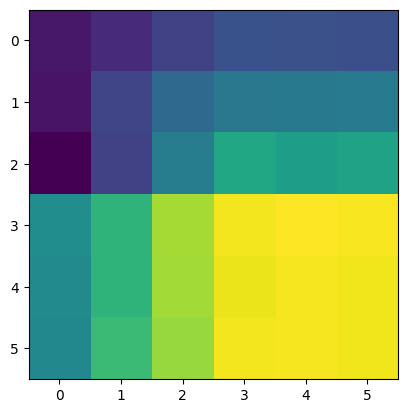

In [25]:
plt.imshow(results)

*If I get a graph that looks useful, I then go to the matplotlib website and try and figure out how to make it more useful... This was a bit fiddly, but here's what I came up with after reading that website and googling around a bit :-)*

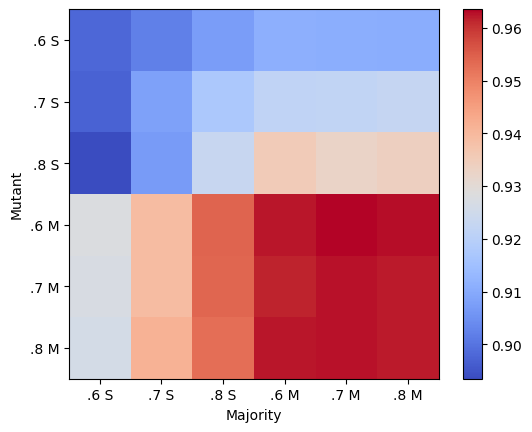

In [26]:
fig, ax = plt.subplots(1, 1)
fig = ax.imshow(results, extent=[0,6,6,0], cmap='coolwarm')

labels = ['.6 S', '.7 S', '.8 S', '.6 M', '.7 M', '.8 M']

ax.set_xticks([.5,1.5,2.5,3.5,4.5,5.5])
ax.set_xticklabels(labels)

ax.set_yticks([.5,1.5,2.5,3.5,4.5,5.5])
ax.set_yticklabels(labels)

ax.set_ylabel("Mutant")
ax.set_xlabel("Majority")

plt.colorbar(fig)

*So, it looks like there are general differences in strategy, with MAP learners learning better than samplers. But really, we want to know is not the overall learning success, but whether a mutant learner is better than the majority learner in the population into which it is born. If it is better, then it has a chance of taking over the population. To figure this out we need to know how well the learner will do if born into a population of other learners who are the same and then compare a mutant to this. If you think about it, this is the diagonal of the table above (i.e. when the mutant **is** the learner that created the stationary distribution). We can extract this as follows:*

In [27]:
self_learning = []
for i in range(6):
    self_learning.append(results[i][i])
print(self_learning)

[0.89799, 0.908, 0.92318, 0.96225, 0.96258, 0.96203]


*Now we can compare each cell in the table and see if the learning success for the mutant is higher than the non-mutant, lower or the same.*

In [28]:
for minority in range(6):
    for majority in range(6):
        if results[minority][majority] > self_learning[majority]:
            print(learners[minority], end=' ')
            print('invades a population of', end=' ')
            print(learners[majority])
        elif results[minority][majority] < self_learning[majority]:
            print(learners[minority], end=' ')
            print('dies out in a population of', end=' ')
            print(learners[majority])

(0.6, 'sample') dies out in a population of (0.7, 'sample')
(0.6, 'sample') dies out in a population of (0.8, 'sample')
(0.6, 'sample') dies out in a population of (0.6, 'map')
(0.6, 'sample') dies out in a population of (0.7, 'map')
(0.6, 'sample') dies out in a population of (0.8, 'map')
(0.7, 'sample') dies out in a population of (0.6, 'sample')
(0.7, 'sample') dies out in a population of (0.8, 'sample')
(0.7, 'sample') dies out in a population of (0.6, 'map')
(0.7, 'sample') dies out in a population of (0.7, 'map')
(0.7, 'sample') dies out in a population of (0.8, 'map')
(0.8, 'sample') dies out in a population of (0.6, 'sample')
(0.8, 'sample') dies out in a population of (0.7, 'sample')
(0.8, 'sample') dies out in a population of (0.6, 'map')
(0.8, 'sample') dies out in a population of (0.7, 'map')
(0.8, 'sample') dies out in a population of (0.8, 'map')
(0.6, 'map') invades a population of (0.6, 'sample')
(0.6, 'map') invades a population of (0.7, 'sample')
(0.6, 'map') invades 

*So, it looks like MAP learners invade populations of samplers often, but never the other way around. Also, it looks like samplers that don't match the specific bias of the population die out, whereas that's not so clearly the case with MAP. However, there's a problem with this way of looking at things. This doesn't show us how big an advantage one type of learner has over another, and because these are simulation runs, the results are going to be quite variable and we might have a tiny difference showing up just by chance. Because of this, let's instead plot the results but using a ratio of mutant success to majority success. This will give us an estimate of the **selective advantage** the mutant has. We'll make a new table and ratios and plot this.*

In [29]:
new_results = []
for minority in range(6):
    new_row = []
    for majority in range(6):
        new_row.append(results[minority][majority] / self_learning[majority])
    new_results.append(new_row)

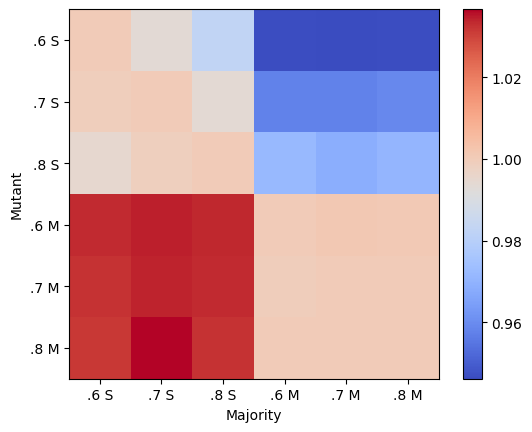

In [30]:
fig, ax = plt.subplots(1, 1)
fig = ax.imshow(new_results, extent=[0,6,6,0], cmap='coolwarm')

labels = ['.6 S', '.7 S', '.8 S', '.6 M', '.7 M', '.8 M']

ax.set_xticks([.5,1.5,2.5,3.5,4.5,5.5])
ax.set_xticklabels(labels)

ax.set_yticks([.5,1.5,2.5,3.5,4.5,5.5])
ax.set_yticklabels(labels)

ax.set_ylabel("Mutant")
ax.set_xlabel("Majority")

plt.colorbar(fig)

*So, from this plot, we can see clearly that MAP learners will invade sampling populations (the ratios in the bottom left are >1), but not vice versa (the ratios in the top right are <1). Also, there isn't a clear difference between different bias strengths. At least for MAP learners, the strong biases are no more likely to invade the weaker biases. This means that if there is some cost to maintaining a strong bias, or if mutations are likely to degrade rather than strengthen strong biases, we can expect to end up with MAP learners with weak biases. The important point is that weakly biased MAP learners have the same stationary distribution as strongly biased MAP learners. That means that even for cases where we see strong universal patterns in language, we should not expect that to be supported by strong innate constraints. These kinds of constraints are not likely to evolve even if selection is favouring learners who can learn the language of the population they're born into!*